In [1]:
import sys
import os
sys.path.append(sys.path[0] + "/..")

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from jupyterthemes import jtplot
import datetime
jtplot.style()

In [2]:
# directory = '../experiments/data/raw/DJA-stocks'

# dja = []
# for filename in os.listdir(directory):
#     if filename.endswith(".csv"):
#         df = pd.read_csv(directory + "/" + filename)
#         df.name = filename.split('-')[1]
#         df['name'] = df.name
#         df.columns = df.columns.str.replace('\d+', '').str.replace('.', '').str.replace(' ', '')
#         dja.append(df)
        
# df_dja = pd.concat(dja, axis=0)
# df_dja.to_csv('../experiments/data/raw/DJA-2000-2020.csv')

In [3]:
# df_dja = df_dja.drop(['volume'], axis=1)
# df_dja.to_csv('../experiments/data/interim/DJA-2000-2020-clean.csv')

In [4]:
df_dja = pd.read_csv('../experiments/data/interim/DJA-2000-2020-clean.csv')
df_dja['date'] = pd.to_datetime(df_dja['date'])
df_dja.set_index('date', inplace=True)
df_dja = df_dja.drop('Unnamed: 0', axis=1)
df_dja.head()

,open,high,low,close,name
date,,,,,
2000-05-11,101.37,104.25,99.00,102.81,AAPL
2000-05-12,106.00,110.50,104.77,107.62,AAPL
2000-05-15,108.06,108.06,100.12,101.00,AAPL
2000-05-16,104.52,109.06,102.75,105.69,AAPL
2000-05-17,103.62,103.69,100.37,101.37,AAPL


In [5]:
df_dja = df_dja[(df_dja['name'] != 'V') & (df_dja['name'] != 'DOW')]

In [6]:
from hedgepy.core import build_series, build_network_time_series
from hedgepy.utils import write_series, read_series, read_data

# dja_series = build_series(df=df_dja, ticker_col_name='name', rolling_window=90, detrend=True, coalesce=True)

In [7]:
# write_series(dja_series, file_name='DJA-2000-2020-rolling-90d-dcor.json')
dja_series = read_series('DJA-2000-2020-rolling-90d-dcor.json')

In [8]:
# not sure why first df is all nans... will have to loops over dict and drop if df contains any nans
dja_series.pop(pd.Timestamp('2000-09-18 00:00:00'))

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,NKE,PFE,PG,RTX,TRV,UNH,VZ,WBA,WMT,XOM
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_dja_index = pd.read_csv('../experiments/data/raw/DJA-index/DJA-2000-2020-index.csv')
df_dja_index['Date'] = pd.to_datetime(df_dja_index['Date'])
df_dja_index.set_index('Date', inplace=True)
df_dja_index.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-11,10369.269531,10575.099609,10369.269531,10545.969727,10545.969727,185720000
2000-05-12,10549.059570,10673.790039,10543.919922,10609.370117,10609.370117,137770000
2000-05-15,10606.969727,10811.549805,10605.259766,10807.780273,10807.780273,155810000
2000-05-16,10816.009766,10971.240234,10816.009766,10934.570313,10934.570313,181920000
2000-05-17,10930.639648,10930.639648,10752.610352,10769.740234,10769.740234,169570000


In [10]:
from hedgepy.centrality import global_degree_centrality, global_eigencentrality

nx_ts_soft = build_network_time_series(dja_series, soft_threshold=True)

In [11]:
nx_ts_02 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.2)
nx_ts_03 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.3)
nx_ts_04 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.4)
nx_ts_05 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.5)
nx_ts_06 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.6)
nx_ts_07 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.7)
nx_ts_08 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.8)
nx_ts_09 = build_network_time_series(dja_series, soft_threshold=False, corr_threshold=0.9)

In [12]:
nx_ts_list = [nx_ts_02, nx_ts_03, nx_ts_04, nx_ts_05, nx_ts_06, nx_ts_07, nx_ts_08, nx_ts_09]

df_list = [global_degree_centrality(G) for G in nx_ts_list]
df_dc = pd.concat(df_list, axis=1)

In [13]:
df_ec = global_eigencentrality(nx_ts_soft)

In [14]:
col_names = [f'dcor > {i}' for i in [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]]
df_dc.columns = col_names

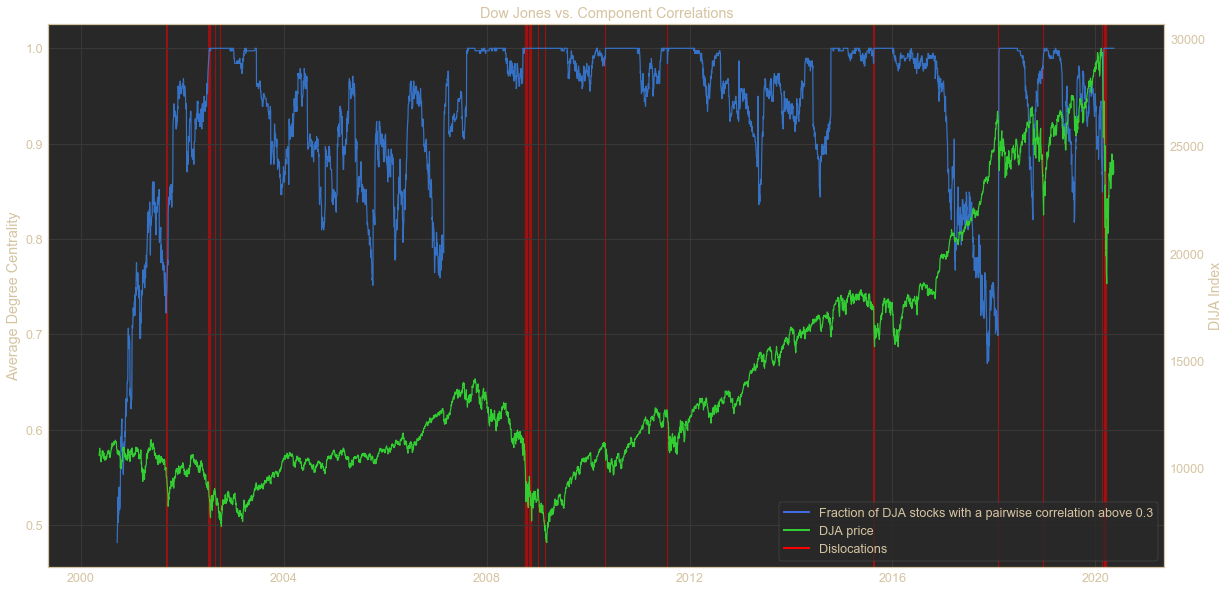

In [69]:
from matplotlib.lines import Line2D
colors = ['royalblue', 'limegreen', 'red']
lines = [ Line2D([0], [0], color=c, linewidth=2) for c in colors ]
labels = ['Fraction of DJA stocks with a pairwise correlation above 0.3', 'DJA price', 'Dislocations']

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_dc['dcor > 0.3'])
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(dislocations['d_start'], dislocations['d_end'])]
ax.set_ylabel('Average Degree Centrality')
ax.set_title('Dow Jones vs. Component Correlations')
plt.legend(lines, labels)
ax2 = ax.twinx()
ax2.plot(df_dja_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
ax2.grid(False)
# plt.savefig('../experiments/resources/dja-correlation-above-03-2000-2020', bbox_inches="tight")

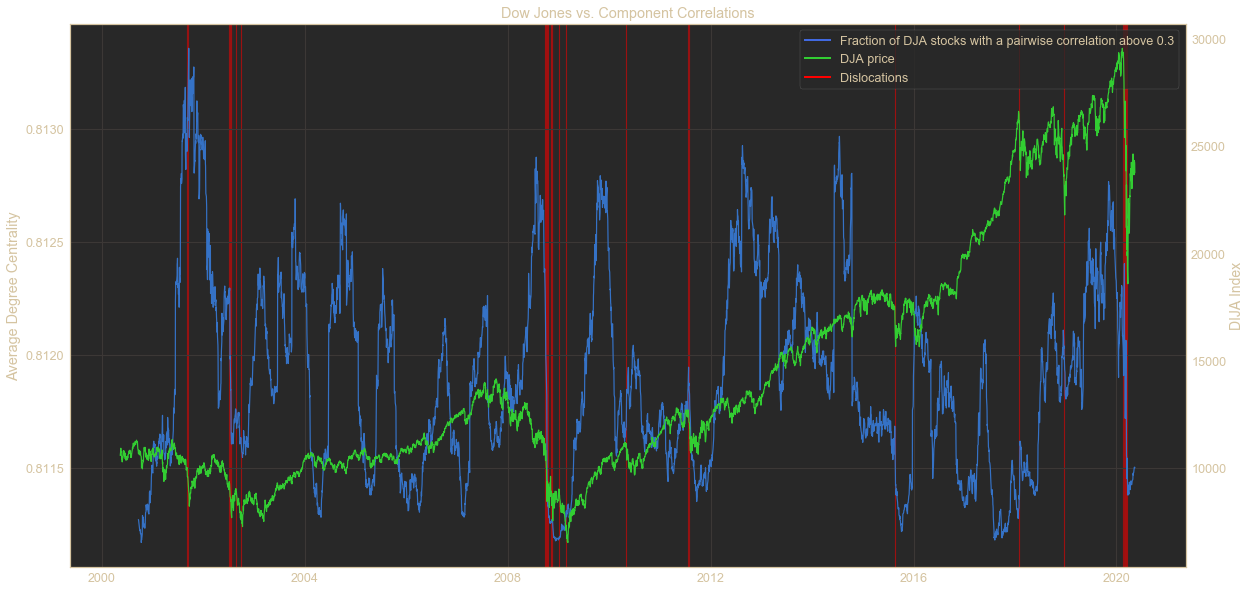

In [68]:
from matplotlib.lines import Line2D
colors = ['royalblue', 'limegreen', 'red']
lines = [ Line2D([0], [0], color=c, linewidth=2) for c in colors ]
labels = ['Fraction of DJA stocks with a pairwise correlation above 0.3', 'DJA price', 'Dislocations']

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(1 - df_ec['global_eigencentrality'])
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(dislocations['d_start'], dislocations['d_end'])]
ax.set_ylabel('Average Degree Centrality')
ax.set_title('Dow Jones vs. Component Correlations')
plt.legend(lines, labels)
ax2 = ax.twinx()
ax2.plot(df_dja_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
ax2.grid(False)

In [17]:
df_gtest = pd.DataFrame({'DJA': df_dja_index['Close'], 'eigen': (df_ec['global_eigencentrality'])})
df_gtest.dropna(inplace=True)

In [18]:
df_gtest2 = pd.DataFrame({'DJA': df_dja_index['Close'], 'deg_03': df_dc['dcor > 0.3']})
df_gtest2.dropna(inplace=True)

In [19]:
df_gtest.head()

,DJA,eigen
2000-09-19,10789.290039,0.188723
2000-09-20,10687.919922,0.188731
2000-09-21,10765.519531,0.188734
2000-09-22,10847.370117,0.188740
2000-09-25,10808.150391,0.188755


In [20]:
from statsmodels.tsa.stattools import grangercausalitytests, coint, adfuller
gc = grangercausalitytests(df_gtest, 252, verbose=False)

In [90]:
adfuller(df_gtest['eigen'])

(-4.694846887816551,
 8.604864802091564e-05,
 9,
 4932,
 {'1%': -3.4316765828777305,
  '5%': -2.8621262044041633,
  '10%': -2.5670820376208074},
 -83575.85890562674)

In [22]:
aic_scores = []
for lag in range(1, 252):
    aic = gc[lag][1][0].aic
    aic_scores.append(aic)

In [86]:
aic_df = pd.DataFrame({'lags': list(range(1,252)), 'aic_score': aic_scores})

In [85]:
p_values_lr = []
p_values_ft = []
p_values_chi = []
for lag in range(1, 252):
    lrtest = gc[lag][0]['lrtest'][1]
    ftest = gc[lag][0]['ssr_chi2test'][1]
    chi2test = gc[lag][0]['params_ftest'][1]
    p_values_lr.append(lrtest)
    p_values_ft.append(ftest)
    p_values_chi.append(chi2test)
    
gtest_df = pd.DataFrame({'lrtest': p_values_lr, 'ftest': p_values_ft, 'chi2test': p_values_chi})
gtest_df.head()

,lrtest,ftest,chi2test
0,0.361475,0.361455,0.361645
1,0.167869,0.167761,0.168173
2,0.255456,0.255280,0.256021
3,0.172540,0.172270,0.173220
4,0.037940,0.037732,0.038279


In [89]:
gtest_aic_df = gtest_df.merge(aic_df, right_index=True, left_index=True)
gtest_aic_df.head()

,lrtest,ftest,chi2test,lags,aic_score
0,0.361475,0.361455,0.361645,1,65150.676579
1,0.167869,0.167761,0.168173,2,65012.351423
2,0.255456,0.255280,0.256021,3,64981.387853
3,0.172540,0.172270,0.173220,4,64956.931896
4,0.037940,0.037732,0.038279,5,64937.221483


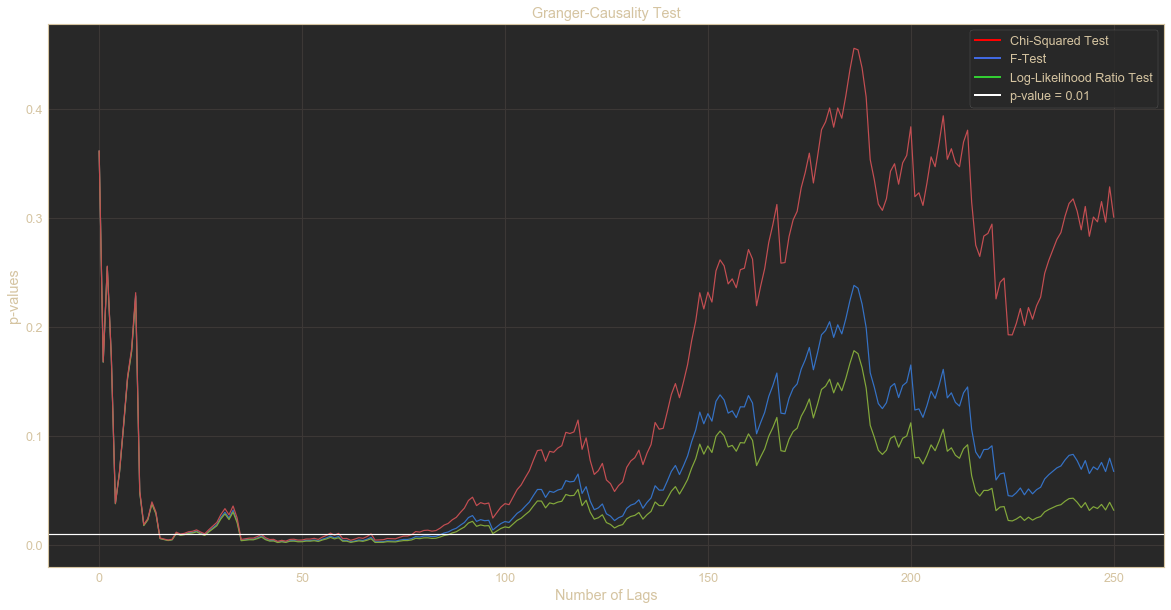

In [83]:
plt.plot(p_values_lr)
plt.plot(p_values_ft)
plt.plot(p_values_chi)
plt.title('Granger-Causality Test')
plt.ylabel('p-values')
plt.xlabel('Number of Lags')
plt.axhline(0.01, color='white')

colors = ['red', 'royalblue', 'limegreen', 'white']
lines = [ Line2D([0], [0], color=c, linewidth=2) for c in colors ]
labels = ['Chi-Squared Test', 'F-Test', 'Log-Likelihood Ratio Test', 'p-value = 0.01']
plt.legend(lines, labels)

In [110]:
#ftest aic
sig_gtest = gtest_aic_df[(gtest_aic_df['ftest'] < 0.01)]
sig_gtest[sig_gtest['aic_score'] == sig_gtest['aic_score'].min()]

,lrtest,ftest,chi2test,lags,aic_score
86,0.011817,0.009289,0.019679,87,63685.990043


In [111]:
#lrtest aic
sig_gtest = gtest_aic_df[(gtest_aic_df['lrtest'] < 0.01)]
sig_gtest[sig_gtest['aic_score'] == sig_gtest['aic_score'].min()]

,lrtest,ftest,chi2test,lags,aic_score
84,0.009158,0.007165,0.015292,85,63710.622802


In [112]:
#chi2test aic
sig_gtest = gtest_aic_df[(gtest_aic_df['chi2test'] < 0.01)]
sig_gtest[sig_gtest['aic_score'] == sig_gtest['aic_score'].min()]

,lrtest,ftest,chi2test,lags,aic_score
77,0.005765,0.00454,0.009357,78,63789.572388


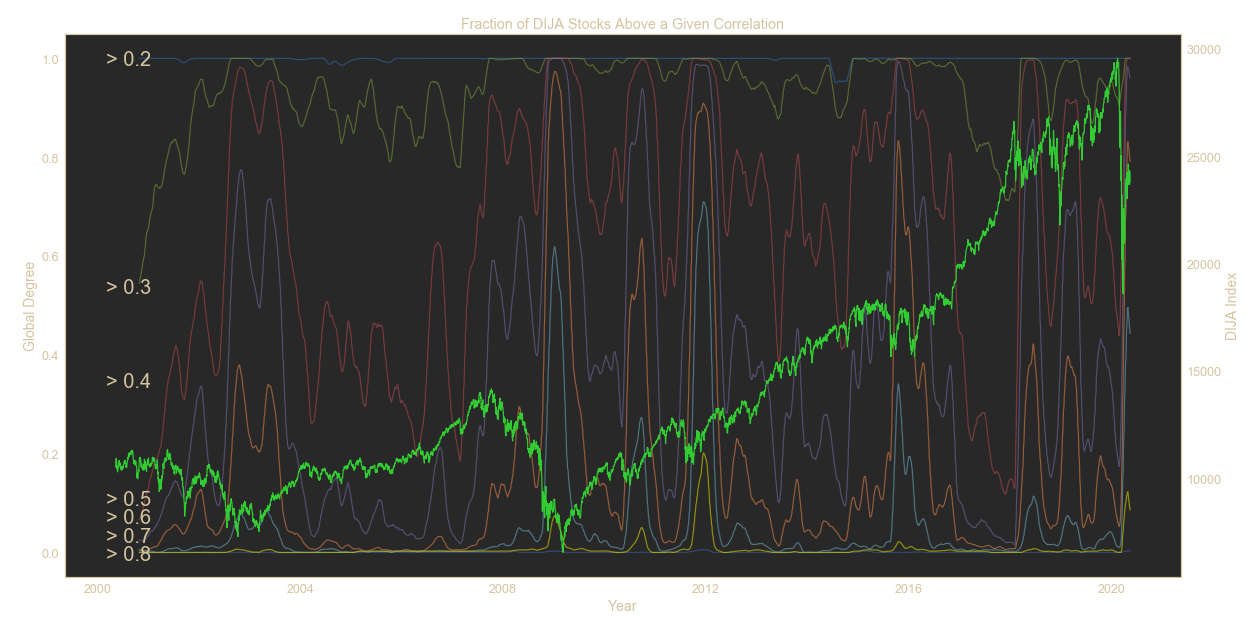

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
for col in df_dc.columns:
    ax.plot(df_dc[col].rolling(30).mean(), alpha=0.5)
    
ax.plot(df_dc['dcor > 0.8'].rolling(30).mean(), alpha=0.5, color='yellow')
# [plt.axvspan(x1, x2, alpha=0.5, color='red', linestyle='dotted') for x1, x2 in zip(dislocations['d_start'], dislocations['d_end'])]

ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Global Degree", fontsize=14)
ax.set_title('Fraction of DIJA Stocks Above a Given Correlation')
ax.grid(False)
ax.annotate('> 0.2',
            xy=(0.085, .918), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.3',
            xy=(0.085, .55), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.4',
            xy=(0.085, .40), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.5',
            xy=(0.085, .21), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.6',
            xy=(0.085, .18), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.7',
            xy=(0.085, .15), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)
ax.annotate('> 0.8',
            xy=(0.085, .12), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=20)

ax2 = ax.twinx()
ax2.plot(df_dja_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
ax2.grid(False)
# plt.savefig('../experiments/resources/dja-correlation-gradient-2000-2020', bbox_inches="tight")

In [31]:
df_ec['pct_change'] = df_ec[['global_eigencentrality']].pct_change()
df_ec.dropna(inplace=True)

In [32]:
def optimize_OneClassSVM(X, n):
    print('searching for optimal hyperparameters...')
    nu = np.linspace(start=1e-5, stop=1e-2, num=n)
    gamma = np.linspace(start=1e-6, stop=1e-3, num=n)
    opt_diff = 1.0
    opt_nu = None
    opt_gamma = None
    for i in range(len(nu)):
        for j in range(len(gamma)):
            classifier = OneClassSVM(kernel="rbf", nu=nu[i], gamma=gamma[j])
            classifier.fit(X)
            label = classifier.predict(X)
            p = 1 - float(sum(label == 1.0)) / len(label)
            diff = math.fabs(p - nu[i])
            if diff < opt_diff:
                opt_diff = diff
                opt_nu = nu[i]
                opt_gamma = gamma[j]
    return opt_nu, opt_gamma

In [33]:
X_train = df_ec[['pct_change']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(np_scaled).dropna()

opt_nu, opt_gamma = optimize_OneClassSVM(X_train, n=20)

searching for optimal hyperparameters...


In [34]:
print(opt_nu)
print(opt_gamma)

0.007896842105263159
5.357894736842106e-05


In [35]:
model = OneClassSVM(nu=1/np.sqrt(len(df_ec)), kernel='rbf', gamma=1/len(df_ec))
model.fit(X_train)
anomalies = pd.Series(model.predict(X_train), index=df_ec.index)

In [36]:
1/np.sqrt(len(df_ec))

0.014226319992543996

In [37]:
df_ec['anomalies'] = anomalies
df_ec['DJA'] = df_dja_index['Close']

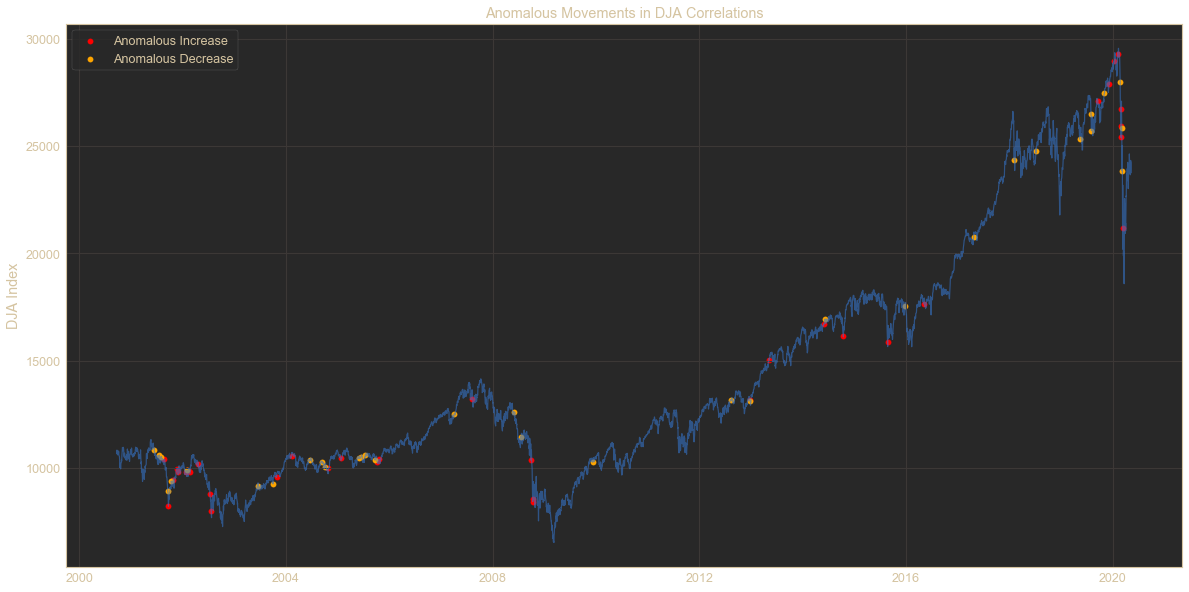

In [38]:
a = df_ec.loc[(df_ec['anomalies'] == -1)]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ec.index, df_ec['DJA'], alpha=0.6)

b = a.loc[a['pct_change'] > 0]
c = a.loc[a['pct_change'] < 0]

bsize = np.abs([(i*10000)**1.5 for i in b['pct_change'].tolist()])
csize = np.abs([(i*10000)**1.5 for i in c['pct_change'].tolist()])
ax.scatter(df_ec['DJA'][(df_ec['anomalies']==-1) & (df_ec['pct_change'] > 0)].index, df_ec['DJA'][(df_ec['anomalies']==-1) & (df_ec['pct_change'] > 0)], label='Anomalous Increase', color='red')
ax.scatter(df_ec['DJA'][(df_ec['anomalies']==-1) & (df_ec['pct_change'] < 0)].index, df_ec['DJA'][(df_ec['anomalies']==-1) & (df_ec['pct_change'] < 0)], label='Anomalous Decrease', color='orange')

ax.set_title('Anomalous Movements in DJA Correlations')
ax.set_ylabel('DJA Index')
ax.legend()

# plt.savefig('../experiments/resources/dja-anomalies-2000-2020')

In [39]:
a['2020']

,global_eigencentrality,pct_change,anomalies,DJA
2020-01-14,0.188049,0.000700,-1,28939.669922
2020-02-11,0.187870,0.000870,-1,29276.339844
2020-02-24,0.187807,-0.001522,-1,27960.800781
2020-02-28,0.187914,0.001688,-1,25409.359375
2020-03-02,0.188064,0.000798,-1,26703.320313
2020-03-03,0.188192,0.000677,-1,25917.410156
2020-03-06,0.188117,-0.000681,-1,25864.779297
2020-03-09,0.187937,-0.000959,-1,23851.019531
2020-03-12,0.188372,0.001374,-1,21200.619141


In [40]:
len(a)

69

In [41]:
df_dja_index['returns'] = df_dja_index['Close'].pct_change()
df_dja_index.dropna(inplace=True)

In [42]:
def get_drawdowns(price):
    pmin_pmax = (price.diff(-1) > 0).astype(int).diff()
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])

    dd = ((np.array(price[pmin.index])) - np.array(price[pmax.index])) / np.array(price[pmax.index])
    dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
    d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, \
             'duration': dur}    
    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    
    return df_d

In [43]:
df_d = get_drawdowns(df_dja_index['Close'])

In [44]:
df_d

,drawdown,d_start,d_end,duration,rank
Date,,,,,
2008-09-30,-0.221136,2008-09-30,2008-10-10,8,1
2001-09-05,-0.179150,2001-09-05,2001-09-21,12,2
2020-03-10,-0.152591,2020-03-10,2020-03-12,2,3
2020-02-19,-0.134206,2020-02-19,2020-02-28,7,4
2020-03-13,-0.129265,2020-03-13,2020-03-16,1,5
2020-03-04,-0.119592,2020-03-04,2020-03-09,3,6
2015-08-17,-0.107080,2015-08-17,2015-08-25,6,7
2008-11-18,-0.103559,2008-11-18,2008-11-20,2,8
2002-07-17,-0.098349,2002-07-17,2002-07-23,4,9


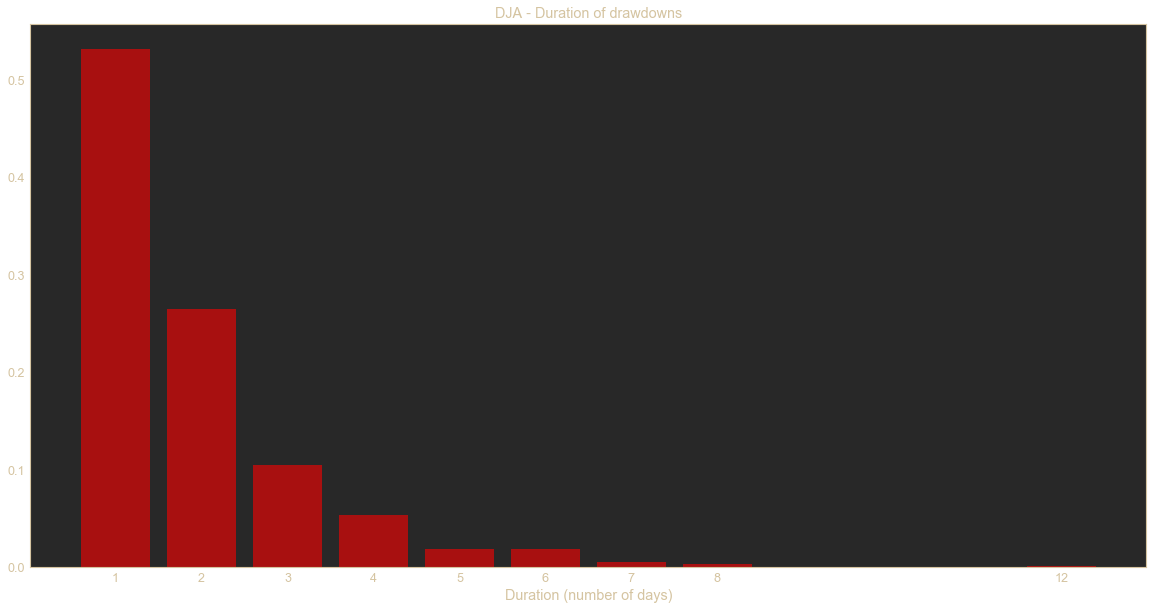

In [45]:
from collections import defaultdict
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

l_dict_dd = []

max_dd = max(abs(df_d['drawdown']))
m = round(max_dd+0.01,2)
bins = np.linspace(-m, m, 800)
d = {}
for i in range(1, len(bins)+1):
    d[i] = bins[i-1]
disc = np.digitize(x=df_d['drawdown'], bins=bins)
d1 = defaultdict(int)
for i in disc:
    d1[d[i]] += 1
l_dict_dd.append(d1)
plt.bar(x=df_d['duration'].value_counts().index, height=df_d['duration'].\
    value_counts()/df_d['duration'].shape[0], color='red', alpha=0.6)
plt.xticks(df_d['duration'].value_counts().index)
plt.title('DJA - Duration of drawdowns')
plt.xlabel('Duration (number of days)')
plt.grid()
plt.show()

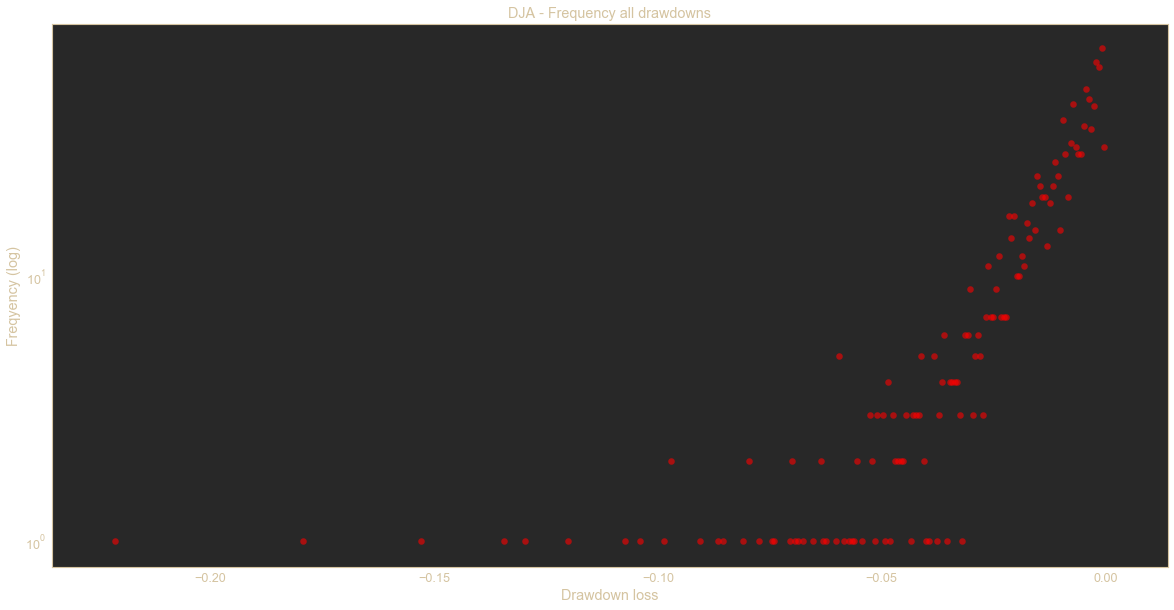

In [46]:
rcParams['figure.figsize'] = 20, 10
for d1 in l_dict_dd:
    df_d_bins = pd.DataFrame(list(d1.items()))
    df_d_bins.columns = ['drawdown', 'n']
    plt.scatter(df_d_bins['drawdown'], df_d_bins['n'], s=40, color='red', alpha=0.6)
    plt.yscale('log')
    df_d_bins_reg = df_d_bins[df_d_bins['drawdown']>-0.08]
#     m, c = np.polyfit(df_d_bins_reg['drawdown'], np.log(df_d_bins_reg['n']), 1)
#     y_fit = np.exp(m*df_d_bins['drawdown'] + c)
    plt.ylim(bottom=10**-.1)
#     plt.plot(df_d_bins['drawdown'], y_fit, color='black', ls='dashed')
    plt.title('DJA - Frequency all drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Freqyency (log)')
    plt.grid()
    plt.show()

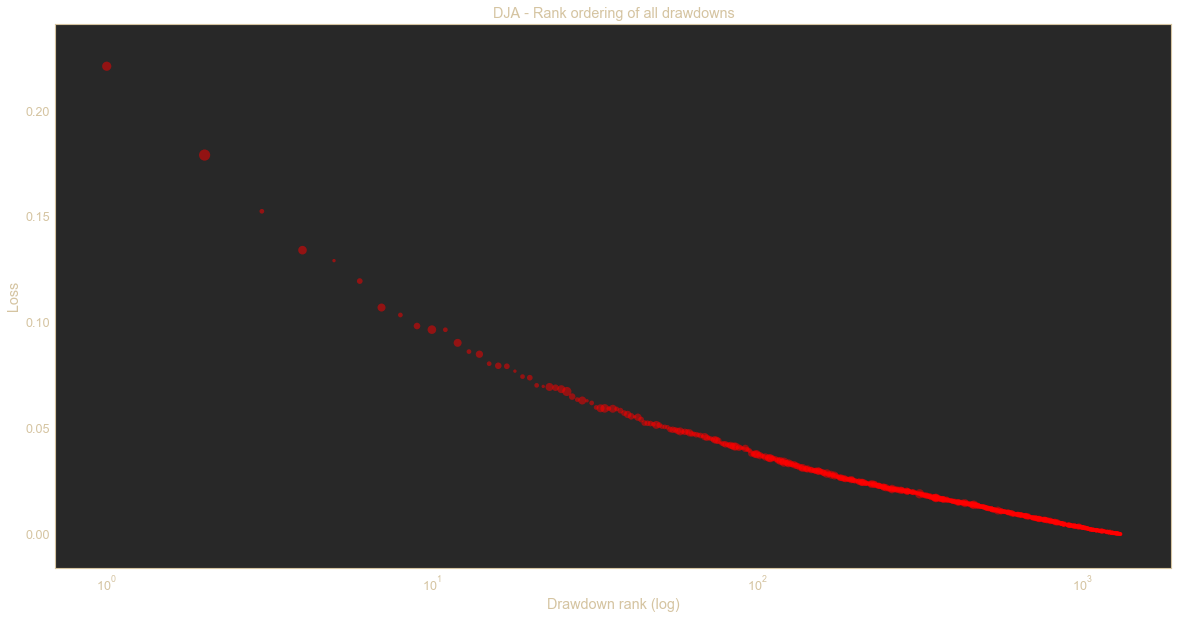

In [47]:
rcParams['figure.figsize'] = 20, 10
plt.scatter(df_d['rank'], abs(df_d['drawdown']), s=10*df_d['duration'], alpha=0.5,\
            color='red')
plt.xscale('log')
plt.title('DJA - Rank ordering of all drawdowns')
plt.xlabel('Drawdown rank (log)')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [48]:
def get_dislocations(df_d, q):
    q = 1 - q
    crashes = df_d[df_d['drawdown'] < df_d.quantile(q)[0]]
    return crashes

dislocations = get_dislocations(df_d, q=0.98)
dislocations.drop([pd.Timestamp('2000-10-04')], inplace=True)

C:\Users\maya.benowitz\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [49]:
dislocations['2002']

,drawdown,d_start,d_end,duration,rank
Date,,,,,
2002-07-17,-0.098349,2002-07-17,2002-07-23,4,9
2002-07-05,-0.096635,2002-07-05,2002-07-16,7,10
2002-07-31,-0.079317,2002-07-31,2002-08-05,3,17
2002-08-26,-0.068501,2002-08-26,2002-09-03,6,25
2002-10-01,-0.064991,2002-10-01,2002-10-07,4,27


Text(0, 0.5, 'Drawdown %')

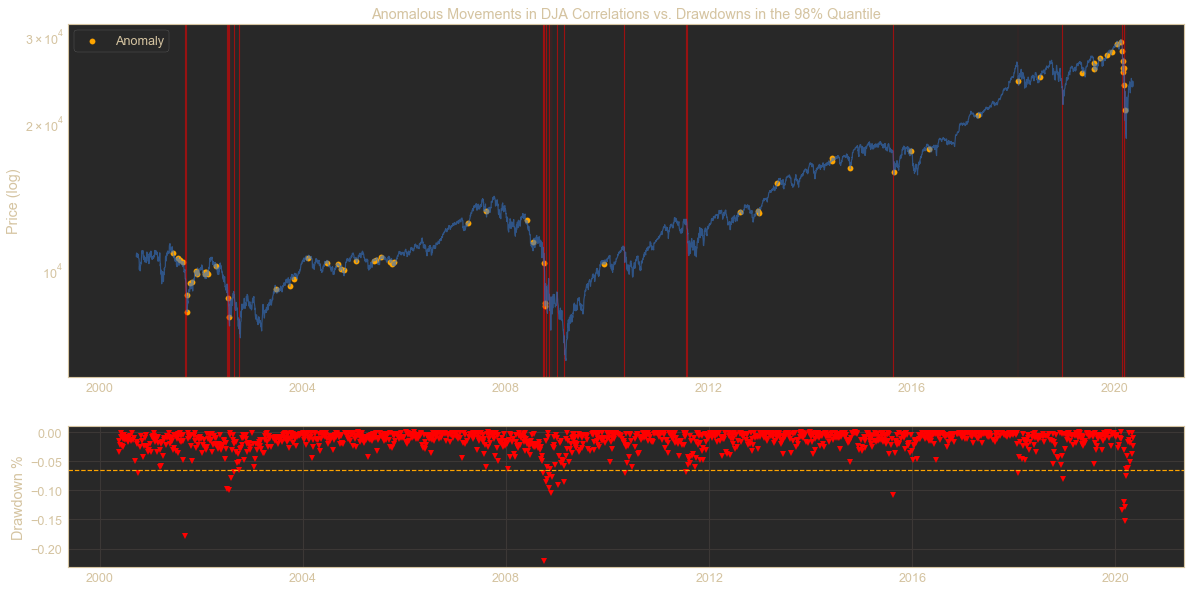

In [50]:
a = df_ec.loc[(df_ec['anomalies'] == -1)]
rcParams['figure.figsize'] = 20,10

gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
plt.subplot(gs[0])
plt.plot(df_ec.index, df_ec['DJA'], alpha=0.6)
[plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(dislocations['d_start'], dislocations['d_end'])]
plt.plot(df_d['drawdown'], color='red', marker='v', linestyle='')

plt.ylabel('Price (log)')
plt.title('Anomalous Movements in DJA Correlations vs. Drawdowns in the 98% Quantile')

plt.scatter(df_ec['DJA'][(df_ec['anomalies']==-1)].index, df_ec['DJA'][(df_ec['anomalies']==-1)], label='Anomaly', color='orange')
plt.legend()
plt.yscale('log')
plt.grid(False)

plt.subplot(gs[1])
plt.plot(df_d['drawdown'], color='red', marker='v', linestyle='')
plt.axhline(dislocations['drawdown'].tolist()[-1], color='orange', linestyle='dashed')
plt.ylabel('Drawdown %')

# plt.savefig('../experiments/resources/dja-anomalies-drawdowns-2000-2020', bbox_inches="tight")

In [51]:
len(a)

69

In [52]:
dislocations

,drawdown,d_start,d_end,duration,rank
Date,,,,,
2008-09-30,-0.221136,2008-09-30,2008-10-10,8,1
2001-09-05,-0.179150,2001-09-05,2001-09-21,12,2
2020-03-10,-0.152591,2020-03-10,2020-03-12,2,3
2020-02-19,-0.134206,2020-02-19,2020-02-28,7,4
2020-03-13,-0.129265,2020-03-13,2020-03-16,1,5
2020-03-04,-0.119592,2020-03-04,2020-03-09,3,6
2015-08-17,-0.107080,2015-08-17,2015-08-25,6,7
2008-11-18,-0.103559,2008-11-18,2008-11-20,2,8
2002-07-17,-0.098349,2002-07-17,2002-07-23,4,9


In [114]:
def recall_score(anomalies, dislocations, pred_range, verbose=False):
    df_dist = pd.DataFrame(index=anomalies.index, columns=dislocations.index)
    
    for i in anomalies.index:
        for j in dislocations.index:
            df_dist.at[i,j] = (i-j).days
    
    hits = [df_dist[i].between(-pred_range, -1) for i in dislocations.index]
    df_hits = pd.concat(hits, axis=1)
    
    disloc_dates = dislocations.index.tolist()
    tp_fn = [True in df_hits[i].tolist() for i in disloc_dates]

    df_tpfn = pd.DataFrame(zip(disloc_dates, tp_fn))
    df_tpfn.columns = ['drawdown', 'predicted']
    
    tp = len(df_tpfn[df_tpfn['predicted'] == True])
    fn = len(df_tpfn[df_tpfn['predicted'] == False])
    
    recall = tp / (tp + fn)
    if not verbose:
        return recall, tp, fn
    if verbose:
        return print('Recall:', recall, '\n\n', df_tpfn)
            
recall_score(a, dislocations, 87, verbose=True)

Recall: 0.7307692307692307 

      drawdown  predicted
0  2008-09-30       True
1  2001-09-05       True
2  2020-03-10       True
3  2020-02-19       True
4  2020-03-13       True
5  2020-03-04       True
6  2015-08-17      False
7  2008-11-18       True
8  2002-07-17       True
9  2002-07-05       True
10 2008-11-04       True
11 2009-01-06      False
12 2008-10-13       True
13 2009-02-24      False
14 2008-10-20       True
15 2018-12-18      False
16 2002-07-31       True
17 2008-11-28       True
18 2020-03-19       True
19 2008-11-07       True
20 2018-02-01      False
21 2008-09-26       True
22 2010-05-03      False
23 2002-08-26       True
24 2011-07-21      False
25 2002-10-01       True


In [115]:
def precision_score(anomalies, dislocations, pred_range, verbose=False):
    df_dist = pd.DataFrame(index=anomalies.index, columns=dislocations.index)
    
    for i in anomalies.index:
        for j in dislocations.index:
            df_dist.at[i,j] = (i-j).days
    
    hits = [df_dist[i].between(-pred_range, -1) for i in dislocations.index]
    df_hits = pd.concat(hits, axis=1)
    
    anom_dates = anomalies.index.tolist()
    disloc_dates = dislocations.index.tolist()
    
    fp = [True in df_hits.loc[i].tolist() for i in anom_dates]
    tp = [True in df_hits[i].tolist() for i in disloc_dates]

    df_fp = pd.DataFrame(zip(anom_dates, fp))
    df_fp.columns = ['anomalies', 'ground']
    
    df_tpfn = pd.DataFrame(zip(disloc_dates, tp))
    df_tpfn.columns = ['drawdown', 'predicted']

    fp = len(df_fp[df_fp['ground'] == False])
    tp = len(df_tpfn[df_tpfn['predicted'] == True])
    
    precision = tp / (tp + fp)
    if not verbose:
        return precision, tp, fp
    if verbose:
        return print('Precision:', precision, '\n\n', df_fp)
    
precision_score(a, dislocations, 87, verbose=True)

Precision: 0.2835820895522388 

     anomalies  ground
0  2001-06-13    True
1  2001-07-19    True
2  2001-07-31    True
3  2001-08-24    True
4  2001-09-17   False
5  2001-09-21   False
6  2001-10-11   False
7  2001-10-25   False
8  2001-11-23   False
9  2001-11-30   False
10 2002-01-25   False
11 2002-01-31   False
12 2002-02-01   False
13 2002-02-12   False
14 2002-02-21   False
15 2002-04-17    True
16 2002-07-11    True
17 2002-07-19    True
18 2003-06-19   False
19 2003-09-30   False
20 2003-10-27   False
21 2004-02-09   False
22 2004-06-21   False
23 2004-09-13   False
24 2004-09-30   False
25 2004-10-27   False
26 2005-01-20   False
27 2005-05-31   False
28 2005-06-13   False
29 2005-07-14   False
..        ...     ...
39 2008-10-10    True
40 2009-12-08   False
41 2012-08-13   False
42 2012-12-21   False
43 2012-12-26   False
44 2013-05-07   False
45 2014-06-04   False
46 2014-06-09   False
47 2014-10-15   False
48 2015-08-24   False
49 2015-12-24   False
50 2016-05-05   False

In [118]:
def f_score(precision, recall, beta):
    f = (1 + beta**2) * (precision*recall)/( (beta**2 * precision) + recall )
    return f

f_score(precision_score(a, dislocations, 87)[0], recall_score(a, dislocations, 87)[0], beta=5)

0.6889818688981868

In [56]:
tp = 28
fn = 5
fp = 36
tn = len(df_ec) - (tp + fn + fp)

In [57]:
def matthews_corrcoeff(tp, fn, fp, tn):
    n = tp*tn - fp*fn
    d = np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return n/d

matthews_corrcoeff(tp,fn,fp,tn)

0.6059213733784244

In [119]:
def balanced_accuracy(precision, recall):
    return 0.5*(precision + recall)

balanced_accuracy(precision_score(a, dislocations, 87)[0], recall_score(a, dislocations, 87)[0])

0.5071756601607348

In [135]:
df_eval = pd.DataFrame({
    'Recall': [
        recall_score(a, get_dislocations(df_d, 0.98), 87, verbose=False)[0],
        recall_score(a, get_dislocations(df_d, 0.985), 87, verbose=False)[0],
        recall_score(a, get_dislocations(df_d, 0.99), 87, verbose=False)[0],
        recall_score(a, get_dislocations(df_d, 0.995), 87, verbose=False)[0],
    ],
    'F-beta score (beta=5)': [
        f_score(precision_score(a, get_dislocations(df_d, 0.98), 87)[0], recall_score(a, get_dislocations(df_d, 0.98), 87)[0], beta=5),
        f_score(precision_score(a, get_dislocations(df_d, 0.985), 87)[0], recall_score(a, get_dislocations(df_d, 0.985), 87)[0], beta=5),
        f_score(precision_score(a, get_dislocations(df_d, 0.99), 87)[0], recall_score(a, get_dislocations(df_d, 0.99), 87)[0], beta=5),
        f_score(precision_score(a, get_dislocations(df_d, 0.995), 87)[0], recall_score(a, get_dislocations(df_d, 0.995), 87)[0], beta=5),

    ],
    'F-beta score (beta=3)': [
        f_score(precision_score(a, get_dislocations(df_d, 0.98), 87)[0], recall_score(a, get_dislocations(df_d, 0.98), 87)[0], beta=3),
        f_score(precision_score(a, get_dislocations(df_d, 0.985), 87)[0], recall_score(a, get_dislocations(df_d, 0.985), 87)[0], beta=3),
        f_score(precision_score(a, get_dislocations(df_d, 0.99), 87)[0], recall_score(a, get_dislocations(df_d, 0.99), 87)[0], beta=3),
        f_score(precision_score(a, get_dislocations(df_d, 0.995), 87)[0], recall_score(a, get_dislocations(df_d, 0.995), 87)[0], beta=3),

    ],
    'F-beta score (beta=1)': [
        f_score(precision_score(a, get_dislocations(df_d, 0.98), 87)[0], recall_score(a, get_dislocations(df_d, 0.98), 87)[0], beta=1),
        f_score(precision_score(a, get_dislocations(df_d, 0.985), 87)[0], recall_score(a, get_dislocations(df_d, 0.985), 87)[0], beta=1),
        f_score(precision_score(a, get_dislocations(df_d, 0.99), 87)[0], recall_score(a, get_dislocations(df_d, 0.99), 87)[0], beta=1),
        f_score(precision_score(a, get_dislocations(df_d, 0.995), 87)[0], recall_score(a, get_dislocations(df_d, 0.995), 87)[0], beta=1),

    ],
    'Precision': [
        precision_score(a, get_dislocations(df_d, 0.98), 87, verbose=False)[0],
        precision_score(a, get_dislocations(df_d, 0.985), 87, verbose=False)[0],
        precision_score(a, get_dislocations(df_d, 0.99), 87, verbose=False)[0],
        precision_score(a, get_dislocations(df_d, 0.995), 87, verbose=False)[0],
    ],
    'Quantile of Drawdowns': [
        '98%', 
        '98.5%', 
        '99%', 
        '99.5%'
    ]
})

In [136]:
df_eval

,Recall,F-beta score (beta=5),F-beta score (beta=3),F-beta score (beta=1),Precision,Quantile of Drawdowns
0,0.703704,0.665768,0.612903,0.404255,0.283582,98%
1,0.800000,0.737589,0.655738,0.380952,0.250000,98.5%
2,0.785714,0.697561,0.591398,0.297297,0.183333,99%
3,0.857143,0.666667,0.491803,0.181818,0.101695,99.5%


In [137]:
df_eval = df_eval.melt(id_vars='Quantile of Drawdowns')
df_eval.columns = ['Quantile of Drawdowns', 'Statistic', 'Score']
df_eval.head()

,Quantile of Drawdowns,Statistic,Score
0,98%,Recall,0.703704
1,98.5%,Recall,0.800000
2,99%,Recall,0.785714
3,99.5%,Recall,0.857143
4,98%,F-beta score (beta=5),0.665768


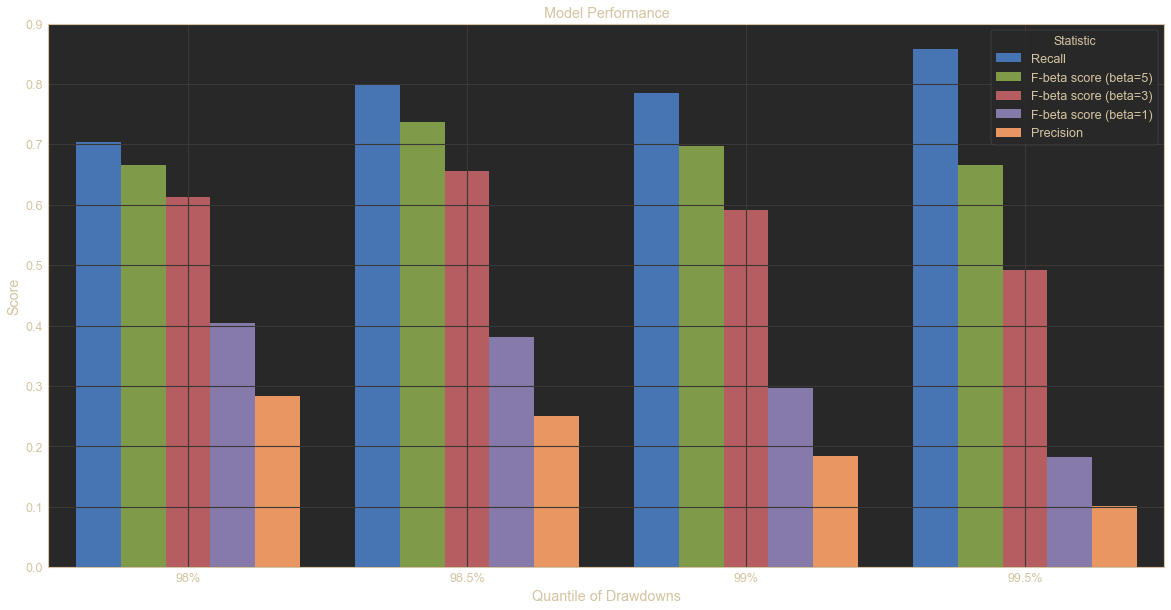

In [138]:
sns.barplot(y='Score', x='Quantile of Drawdowns', hue='Statistic', data=df_eval)
plt.title('Model Performance')
plt.xlabel('Quantile of Drawdowns')
plt.grid(True)
plt.savefig('../experiments/resources/dcor-eigencentrality-svm-perf2-2000-2020', bbox_inches="tight")